## INITIALIZE

In [11]:
import mysql.connector
from sklearn import preprocessing
from scipy.io import arff
from scipy.signal import find_peaks
from mysql.connector import Error
import sqlalchemy
import mysql.connector
import pandas.io.sql as psql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tsfresh.feature_extraction import extract_features,feature_calculators
#from tsfresh import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

## CONNECTOR

In [12]:
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='feldbuslogging',
                                         user='root',
                                         password='Zangetsu10')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("Your connected to database: ", record)
except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if (connection.is_connected()):
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL Server version  8.0.17
Your connected to database:  ('feldbuslogging',)
MySQL connection is closed


In [13]:
mydb = mysql.connector.connect(host='localhost',
                                         database='feldbuslogging',
                                         user='root',
                                         password='Zangetsu10')

## READ FROM TABLE

In [14]:
def readfromtable(tablename, col1, col2, startID, endId):
    mycursor = mydb.cursor()
    #tablename = input("Input Tablename: ")
    #col1 = input("Input Column Name: ")
    #col2 = input("Input Column Name: ")

    #startId = input("Input Start ID: ")
    #endId = input("Input End ID: ")
#mycursor.execute(
  #  "SELECT {col} FROM {tbl} WHERE id>=%s AND id<%s".format(
  #      col=colNames, tbl=tablename
 #   ),
 #   (startId, endId) 2019-01-15 10:32:55.043 2019-01-15 10:55:31.419
#)
    query = "SELECT {col1}, {col2} FROM {tbl} WHERE id>={start} AND id<{end}".format(col1=col1, col2=col2, tbl=tablename, start=startId, end=endId)
    return psql.read_sql(query, con=mydb)

## NORMALIZE

In [207]:
def normalize(factor,df, col1):
    df[col1] = df[col1].apply(lambda x: x*factor)
    return df
    

In [15]:
tablename = input("Input Tablename: ")
col1 = input("Input Column Name: ")
#col3 = input("Input Column Name: ")
col2 = input("Input Column Name: ")
startId = input("Input Start ID: ")
endId = input("Input End ID: ")
df = readfromtable(tablename,col1, col2, startId, endId)
#df = normalize0.03, df, col2)
df.head()
#df['HYD_Hochdruck'] = df['HYD_Hochdruck'].apply(lambda x: x*0.03)
#for i in range(1,len(df)):
#df['id'] = 1

Input Tablename: feldbuslogging.fa_fm_hyd
Input Column Name: Datetime
Input Column Name: HYD_Hochdruck
Input Start ID: 40150
Input End ID: 40300


,Datetime,HYD_Hochdruck
0,2019-01-15 21:42:16.040,311.227
1,2019-01-15 21:42:17.040,309.375
2,2019-01-15 21:42:18.040,307.755
3,2019-01-15 21:42:19.040,305.903
4,2019-01-15 21:42:20.040,304.167


## ADD ID TO THE COLUMN FOR TSFRESH USE

In [43]:
df['id']=[0,1,2,3,4,5,6,7,8,9]

In [20]:
k=0
for i in range(1,len(df)):
    k=k+1
    df.id=k

In [44]:
df

,Datetime,HYD_Netzdruck,HYD_Hochdruck,id
0,2019-01-15 10:32:55.043,91.088,276.157,0
1,2019-01-15 10:32:56.043,87.645,276.273,1
2,2019-01-15 10:32:57.043,86.806,276.273,2
3,2019-01-15 10:32:58.043,88.484,276.157,3
4,2019-01-15 10:32:59.043,84.925,276.273,4
5,2019-01-15 10:33:00.043,88.397,276.157,5
6,2019-01-15 10:33:01.043,86.921,276.157,6
7,2019-01-15 10:33:02.043,85.880,276.157,7
8,2019-01-15 10:33:03.043,86.400,276.157,8
9,2019-01-15 10:33:04.043,88.194,276.157,9


## FEATURE EXTRACTION

## TSFRESH PARAMETRISIERUNG

In [16]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2
settings_time = MinimalFCParameters()
settings_time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

## Umwandlung der DataFrame für tsfresh Nutzung

In [17]:
df.HYD_Hochdruck.values

array([311.227, 309.375, 307.755, 305.903, 304.167, 302.662, 300.81 ,
       299.306, 297.685, 295.949, 294.444, 292.708, 291.204, 289.699,
       288.194, 286.458, 284.954, 263.31 , 268.056, 270.486, 273.958,
       275.926, 280.208, 313.773, 312.037, 310.301, 308.681, 306.829,
       305.093, 303.472, 301.736, 300.116, 298.38 , 296.875, 295.37 ,
       293.634, 292.014, 290.278, 288.773, 287.384, 285.88 , 284.375,
       270.602, 267.13 , 268.981, 271.296, 274.306, 277.315, 309.954,
       309.259, 307.407, 305.671, 304.051, 302.315, 300.694, 298.843,
       297.338, 295.602, 294.097, 292.477, 290.972, 289.236, 287.731,
       286.227, 284.722, 283.102, 262.5  , 265.625, 271.875, 274.19 ,
       277.662, 279.051, 311.806, 310.185, 308.333, 306.481, 304.861,
       303.241, 301.505, 299.884, 298.264, 296.528, 295.023, 293.403,
       291.898, 290.162, 288.657, 287.153, 285.417, 283.912, 282.523,
       281.134, 267.593, 268.171, 273.843, 275.81 , 278.241, 315.856,
       313.31 , 311.

In [21]:
def umwandlung(df, col2):
    col2= input("Input Column Name: ")
    #col2 = input("Input Column Name: ")
    df = pd.DataFrame({#"id": df.id.values, 
                       "value": df[col2].values
                       #"value2": df.[col3].values,


                    },
                       index=pd.DatetimeIndex(
                           df.Datetime
                       ))
    return df

In [47]:
df['value'] = df.HYD_Hochdruck.values
df['value2'] = df.HYD_Netzdruck.values

In [49]:
df.value2

0    91.088
1    87.645
2    86.806
3    88.484
4    84.925
5    88.397
6    86.921
7    85.880
8    86.400
9    88.194
Name: value2, dtype: float64

In [22]:
dfum = umwandlung(df, col2)
dfum


Input Column Name: HYD_Hochdruck


,value
Datetime,
2019-01-15 21:42:16.040,311.227
2019-01-15 21:42:17.040,309.375
2019-01-15 21:42:18.040,307.755
2019-01-15 21:42:19.040,305.903
2019-01-15 21:42:20.040,304.167
2019-01-15 21:42:21.056,302.662
2019-01-15 21:42:22.056,300.810
2019-01-15 21:42:23.040,299.306
2019-01-15 21:42:24.056,297.685


## NORMALIZE

In [11]:
def normalize(df):
    x = df.value - df.value.min()
    y = df.value.max() - df.value.min()
    df.value = x/y
    return df

In [12]:
normalize(dfum)


NameError: name 'dfum' is not defined

## PERIODICITY

TypeError: %d format: a number is required, not Series

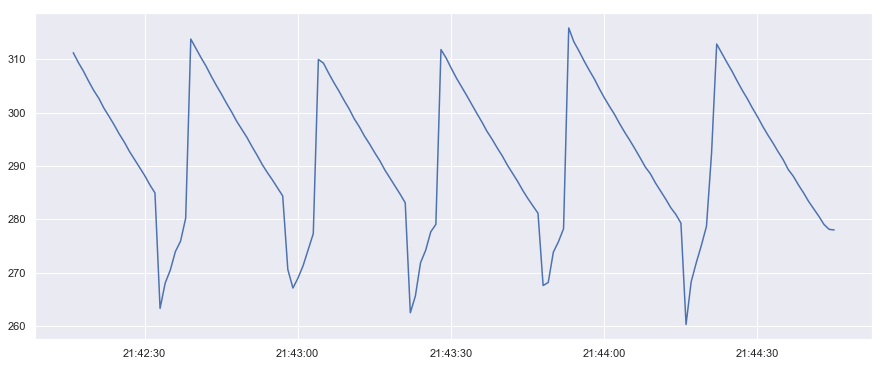

In [23]:
%matplotlib inline
sns.set()
plt.figure(figsize=(15, 6))
plt.plot(dfum.index, dfum.value)
plt.xlabel('% dfum.value' %dfum.value, fontsize=20)
plt.ylabel('%d dfum.value', fontsize=20);
plt.show()

In [35]:
peaks, properties = find_peaks(dfum.value, 
                     height=300)
peaks

array([], dtype=int64)

In [15]:
peaks.shape

(402,)

In [16]:

def clean_signal(signal, periods, sensitivity,period,k):
    ''' add more assertions about inputs
    '''
    j = 0
    k = 0
    output = []
    for p in peaks:
        if p-j in range(period-sensitivity, period+sensitivity):
            output.append(signal[j:p].copy())
            k = k+1
            
        else :
            pass
        j = p
        
    
    return output
    



output = clean_signal(dfum.value, periods=peaks, sensitivity=2,period=24,k=0)
print(output)

[Datetime
2019-01-15 18:53:18.058    313.773
2019-01-15 18:53:19.058    312.037
2019-01-15 18:53:20.043    310.185
2019-01-15 18:53:21.043    308.333
2019-01-15 18:53:22.058    306.481
2019-01-15 18:53:23.043    304.630
2019-01-15 18:53:24.043    303.009
2019-01-15 18:53:25.043    301.157
2019-01-15 18:53:26.027    299.421
2019-01-15 18:53:27.043    297.685
2019-01-15 18:53:28.043    296.065
2019-01-15 18:53:29.058    294.444
2019-01-15 18:53:30.058    292.593
2019-01-15 18:53:31.058    291.088
2019-01-15 18:53:32.058    289.352
2019-01-15 18:53:33.043    287.847
2019-01-15 18:53:34.058    286.227
2019-01-15 18:53:35.043    268.634
2019-01-15 18:53:36.043    266.667
2019-01-15 18:53:37.043    269.676
2019-01-15 18:53:38.043    274.190
2019-01-15 18:53:39.043    277.546
2019-01-15 18:53:40.043    279.745
2019-01-15 18:53:41.043    307.523
Name: value, dtype: float64, Datetime
2019-01-15 18:53:42.074    311.806
2019-01-15 18:53:43.059    309.838
2019-01-15 18:53:44.059    307.986
2019-01

Name: value, dtype: float64]


In [206]:
output[50]

Datetime
2019-01-15 19:21:02.061    312.731
2019-01-15 19:21:03.061    310.764
2019-01-15 19:21:04.046    308.912
2019-01-15 19:21:05.046    307.060
2019-01-15 19:21:06.061    305.440
2019-01-15 19:21:07.046    303.472
2019-01-15 19:21:08.061    301.968
2019-01-15 19:21:09.046    300.231
2019-01-15 19:21:10.031    298.611
2019-01-15 19:21:11.031    296.875
2019-01-15 19:21:12.031    295.023
2019-01-15 19:21:13.047    293.519
2019-01-15 19:21:14.063    292.014
2019-01-15 19:21:15.031    290.278
2019-01-15 19:21:16.031    288.773
2019-01-15 19:21:17.031    287.153
2019-01-15 19:21:18.031    285.417
2019-01-15 19:21:19.031    265.394
2019-01-15 19:21:20.031    269.097
2019-01-15 19:21:21.031    273.843
2019-01-15 19:21:22.031    275.347
2019-01-15 19:21:23.031    278.819
2019-01-15 19:21:24.031    280.556
Name: value, dtype: float64

In [40]:
df = pd.DataFrame({"id": df.id.values, 
                       "value": df[col2].values
                       "value2": df.[col3].values,


                    },
                       index=pd.DatetimeIndex(
                           df.Datetime
                       ))

SyntaxError: invalid syntax (<ipython-input-40-fe08f9711533>, line 3)

In [52]:
df = df.set_index(pd.DatetimeIndex(df['Datetime']))

In [55]:
df2 = df.drop(['Datetime'],axis=1)

In [56]:
df2

,HYD_Netzdruck,HYD_Hochdruck,id,value,value2
Datetime,,,,,
2019-01-15 10:32:55.043,91.088,276.157,0,276.157,91.088
2019-01-15 10:32:56.043,87.645,276.273,1,276.273,87.645
2019-01-15 10:32:57.043,86.806,276.273,2,276.273,86.806
2019-01-15 10:32:58.043,88.484,276.157,3,276.157,88.484
2019-01-15 10:32:59.043,84.925,276.273,4,276.273,84.925
2019-01-15 10:33:00.043,88.397,276.157,5,276.157,88.397
2019-01-15 10:33:01.043,86.921,276.157,6,276.157,86.921
2019-01-15 10:33:02.043,85.880,276.157,7,276.157,85.880
2019-01-15 10:33:03.043,86.400,276.157,8,276.157,86.400


In [50]:
df = pd.DataFrame({"id": df.id.values, 
                       columns=[df.value,df.value2],


                    },
                       index=pd.DatetimeIndex(
                           df.Datetime
                       ))

SyntaxError: invalid syntax (<ipython-input-50-8fb243ee02c8>, line 2)

In [17]:
df2 = pd.DataFrame(output[9])

In [18]:
df2

,value
Datetime,
2019-01-15 18:56:54.054,311.574
2019-01-15 18:56:55.039,309.491
2019-01-15 18:56:56.054,307.755
2019-01-15 18:56:57.054,305.903
2019-01-15 18:56:58.054,304.051
2019-01-15 18:56:59.039,302.315
2019-01-15 18:57:00.039,300.579
2019-01-15 18:57:01.039,298.843
2019-01-15 18:57:02.039,297.222


ValueError: setting an array element with a sequence.

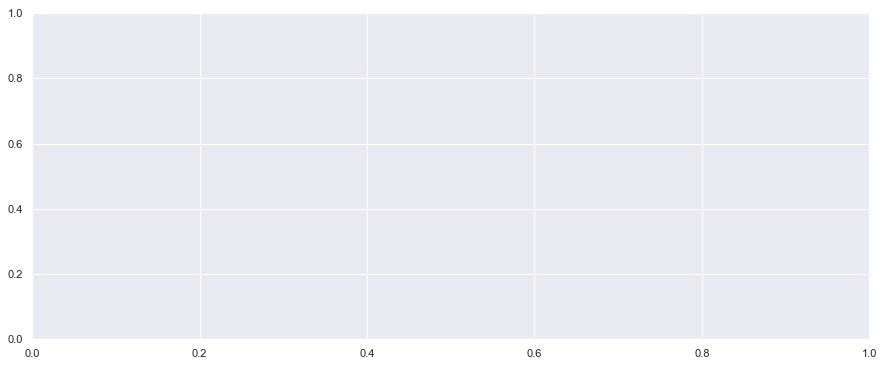

In [21]:
%matplotlib inline
sns.set()
plt.figure(figsize=(15, 6))
plt.plot(output)
#plt.xlabel('% dfum.value' %dfum.value, fontsize=20)
#plt.ylabel('%d dfum.value', fontsize=20);
plt.show()

In [22]:
df = pd.DataFrame(data=output, index=Datetime)

NameError: name 'Datetime' is not defined

## Autocorrelation

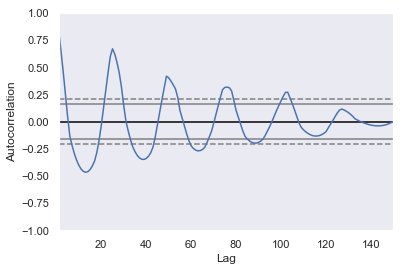

In [25]:
>>> s = pd.Series(dfum.value)
autocorr = [s.autocorr(lag=i) for i in range(2,100)]
pd.plotting.autocorrelation_plot(dfum.value)
plt.savefig("foo3.pdf", bbox_inches='tight')

In [12]:
peaks, _ = find_peaks(autocorr, height=0)

In [25]:
def autocorrelation(dfum):
    s = pd.Series(dfum.value)
    autocorr = [s.autocorr(lag=i) for i in range(2,100)]
    #pd.plotting.autocorrelation_plot(dfum.value);
    peaks, _ = find_peaks(autocorr, height=0)
    #dfum.index = pd.to_datetime(df.Datetime)
    #plt.plot(dfum.index[peaks[1]:peaks[2]+1], dfum.value[peaks[1]:peaks[2]+1
    #'Datetime2': df.index[peaks[1]:peaks[2]+1]
    
    d = {'value': dfum.value[peaks[1]+1:peaks[2]+1]}
    dffinal = pd.DataFrame(data=d)
    for i in range(1,len(df)):
        dffinal['id'] = 1
    return dffinal
    
    




In [26]:
autocorrelation(dfum)

,value,id
Datetime,,
2019-01-15 21:43:04.040,309.954,1
2019-01-15 21:43:05.040,309.259,1
2019-01-15 21:43:06.040,307.407,1
2019-01-15 21:43:07.040,305.671,1
2019-01-15 21:43:08.056,304.051,1
2019-01-15 21:43:09.056,302.315,1
2019-01-15 21:43:10.060,300.694,1
2019-01-15 21:43:11.060,298.843,1
2019-01-15 21:43:12.060,297.338,1


## PLOT EINER PERIODE

In [20]:
plt.plot(dffinal.index,dffinal.value)

NameError: name 'dffinal' is not defined

In [17]:
d = {'value': dfum.value[peaks[1]:peaks[2]+1]}
dffinal = pd.DataFrame(data=d)
for i in range(1,len(df)):
        dffinal['id'] = 1

dffinal

,value,id
Datetime,,
2019-01-15 21:43:03.040,277.315,1
2019-01-15 21:43:04.040,309.954,1
2019-01-15 21:43:05.040,309.259,1
2019-01-15 21:43:06.040,307.407,1
2019-01-15 21:43:07.040,305.671,1
2019-01-15 21:43:08.056,304.051,1
2019-01-15 21:43:09.056,302.315,1
2019-01-15 21:43:10.060,300.694,1
2019-01-15 21:43:11.060,298.843,1


## FFT

In [21]:
fft = np.fft.rfft(dfum.value, norm="ortho")
def abs2(x):
    return x.real**2 + x.imag**2
selfconvol = np.fft.irfft(abs2(fft), norm="ortho")

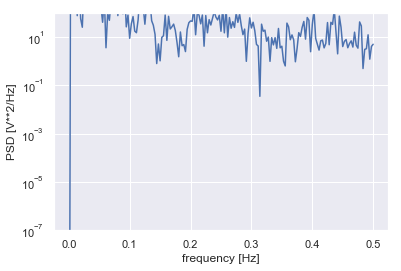

In [22]:
from scipy import signal
import matplotlib.pyplot as plt
fs = 1
f, Pxx_den = signal.periodogram(dfum.value, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## FEATURE VEKTOR

In [33]:
def feature_extraction(df):
    import pandas as pd
    X_tsfresh = extract_features(df, column_id="id",
                                 default_fc_parameters=settings_time)
    df = X_tsfresh
    
    #df2.replace(to_replace='value__agg_linear_trend__f_agg_"max"__chunk_len_', value='linear', regex=True)




    
    return X_tsfresh

In [57]:
dfextract = feature_extraction(df2)
dfextract.head()


Feature Extraction: 100%|██████████████████████| 10/10 [00:03<00:00,  3.17it/s]

variable,HYD_Hochdruck__length,HYD_Hochdruck__maximum,HYD_Hochdruck__mean,HYD_Hochdruck__median,HYD_Hochdruck__minimum,HYD_Hochdruck__standard_deviation,HYD_Hochdruck__sum_values,HYD_Hochdruck__variance,HYD_Netzdruck__length,HYD_Netzdruck__maximum,...,value2__sum_values,value2__variance,value__length,value__maximum,value__mean,value__median,value__minimum,value__standard_deviation,value__sum_values,value__variance
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,276.157,276.157,276.157,276.157,0.0,276.157,0.0,1.0,91.088,...,91.088,0.0,1.0,276.157,276.157,276.157,276.157,0.0,276.157,0.0
1,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0,1.0,87.645,...,87.645,0.0,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0
2,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0,1.0,86.806,...,86.806,0.0,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0
3,1.0,276.157,276.157,276.157,276.157,0.0,276.157,0.0,1.0,88.484,...,88.484,0.0,1.0,276.157,276.157,276.157,276.157,0.0,276.157,0.0
4,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0,1.0,84.925,...,84.925,0.0,1.0,276.273,276.273,276.273,276.273,0.0,276.273,0.0


In [38]:
dfextract.T

id,0,1,2,3,4,5,6,7,8,9
variable,,,,,,,,,,
value__length,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
value__maximum,276.157,276.273,276.273,276.157,276.273,276.157,276.157,276.157,276.157,276.157
value__mean,276.157,276.273,276.273,276.157,276.273,276.157,276.157,276.157,276.157,276.157
value__median,276.157,276.273,276.273,276.157,276.273,276.157,276.157,276.157,276.157,276.157
value__minimum,276.157,276.273,276.273,276.157,276.273,276.157,276.157,276.157,276.157,276.157
value__standard_deviation,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
value__sum_values,276.157,276.273,276.273,276.157,276.273,276.157,276.157,276.157,276.157,276.157
value__variance,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [126]:
dfextract.T

id,1
variable,
value__length,18.000000
value__maximum,9.336810
value__mean,8.844715
value__median,8.904510
value__minimum,8.177070
value__standard_deviation,0.351654
value__sum_values,159.204870
value__variance,0.123661


In [ ]:

#dfextract = dfextract.rename(columns=lambda x: x.replace('agg_autocorrelation_', ''))
#dfextract = dfextract.rename(columns=lambda x: x.replace('value___f_agg_', ''))

#dfextract = dfextract.T
#dfextract.head()

## WRITE TO TABLE FUNCTION

In [19]:
def write_to_table(df, table_name):
    database_username = 'root'
    database_password = 'Zangetsu10'
    database_ip       = 'localhost'
    database_name     = 'feldbuslogging'
    database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                                   format(database_username, database_password, 
                                                          database_ip, database_name))
    df.to_sql(con=database_connection, name=table_name , if_exists='append')

In [20]:
table_name = input("Insert Table Name :")
write_to_table(df2, table_name)

Insert Table Name :fuckyou
